Creates a graphical comparison of cant alignments from IFC-Rail-Unit-Test-Reference-Code and IfcOpenShell

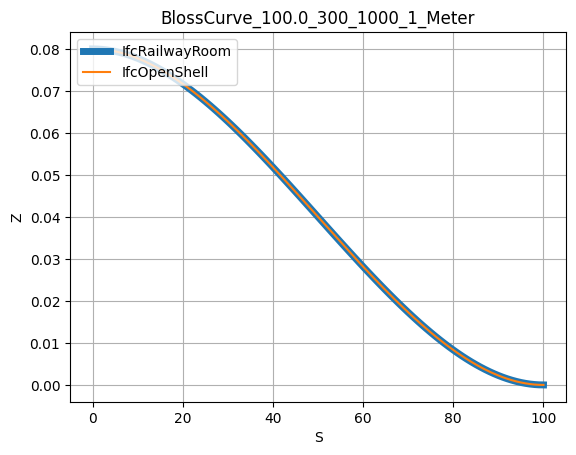

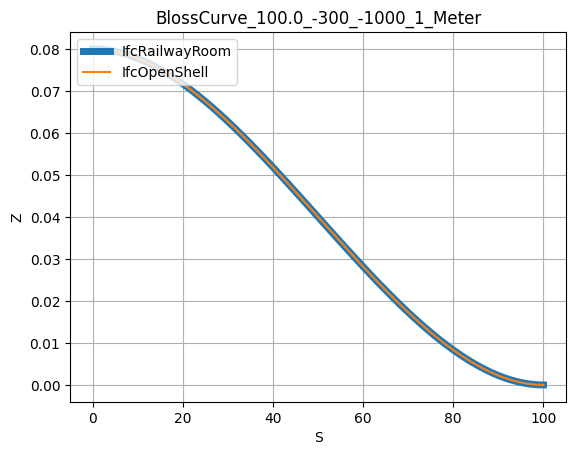

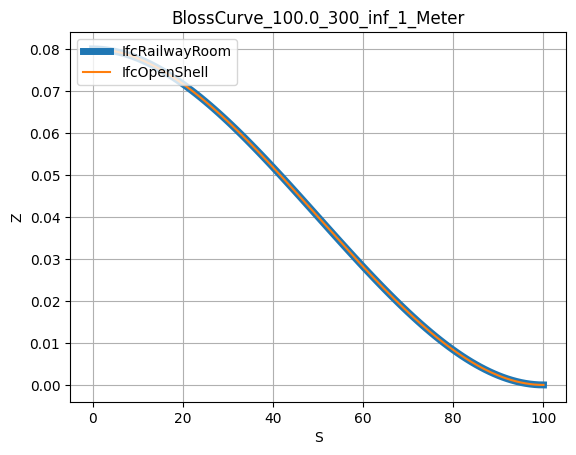

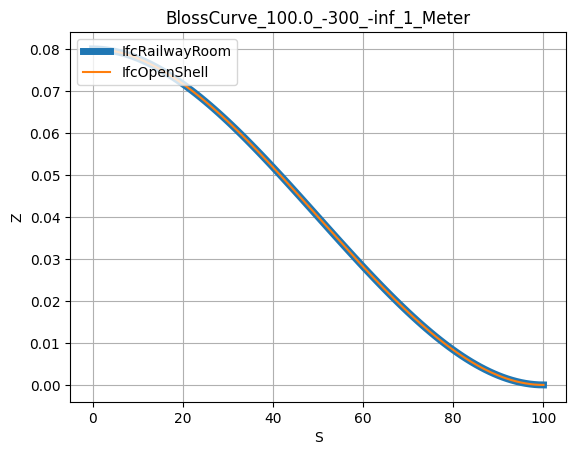

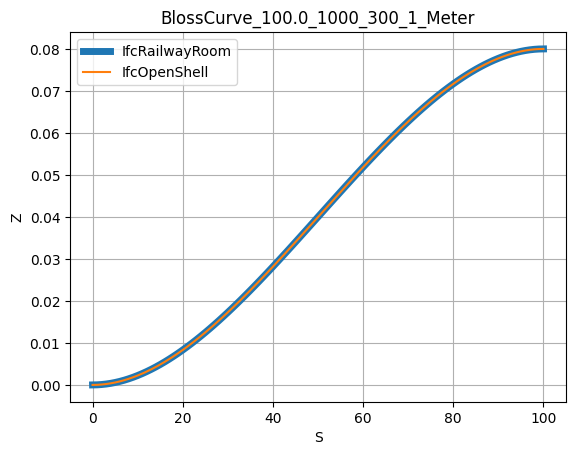

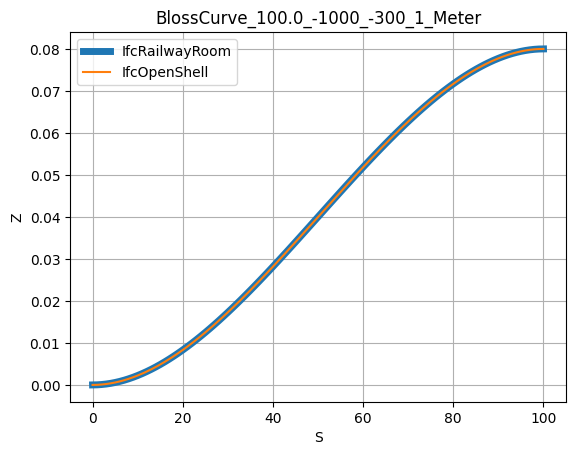

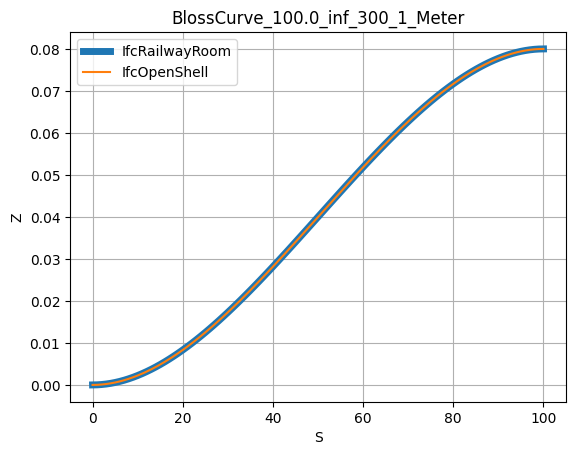

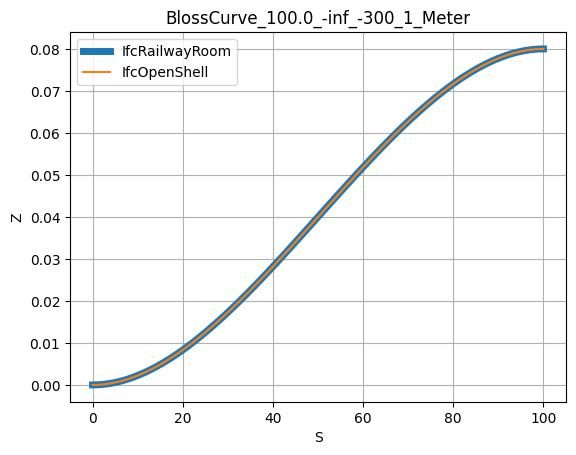

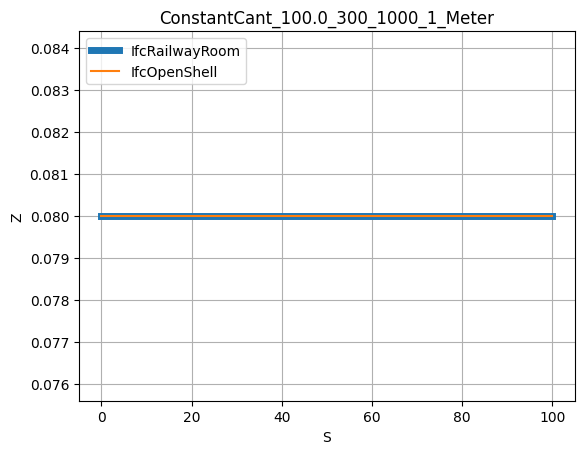

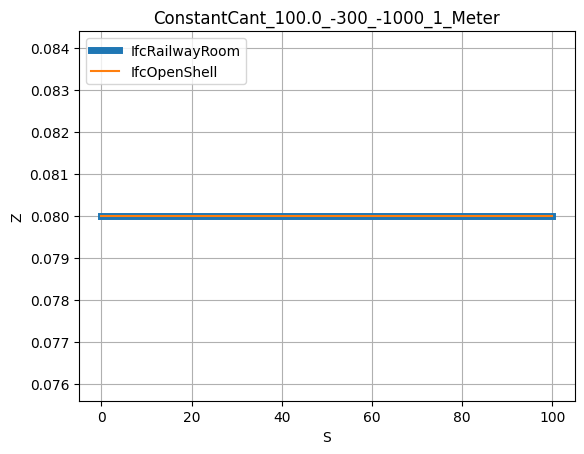

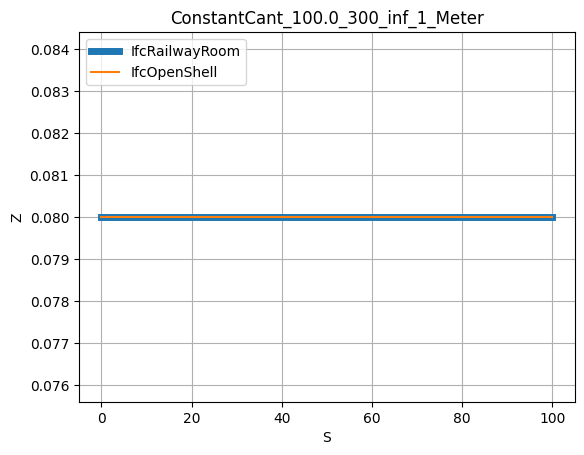

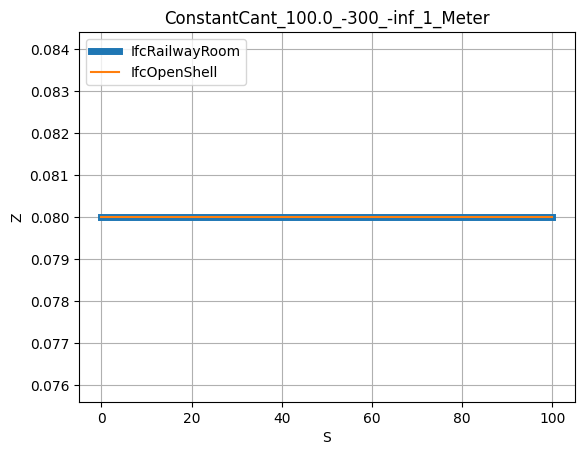

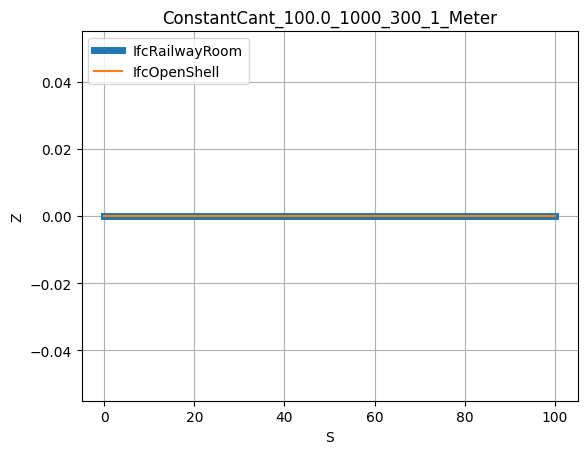

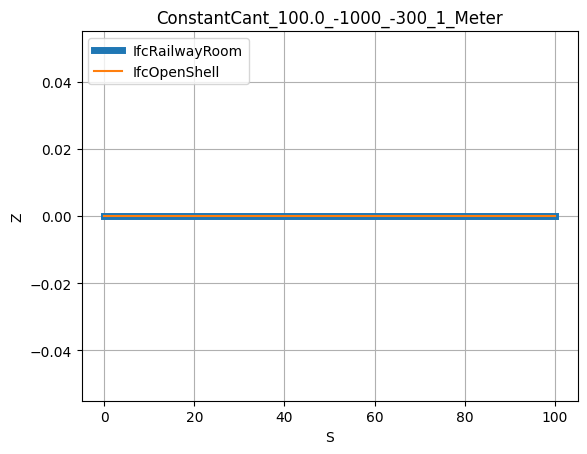

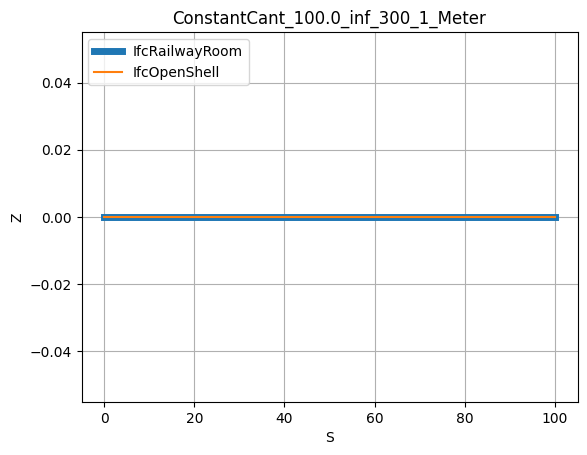

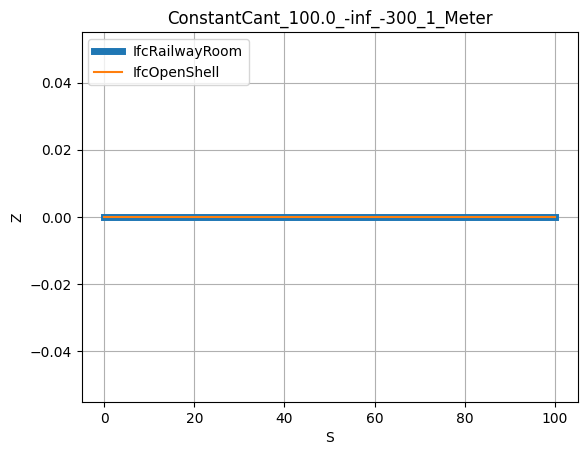

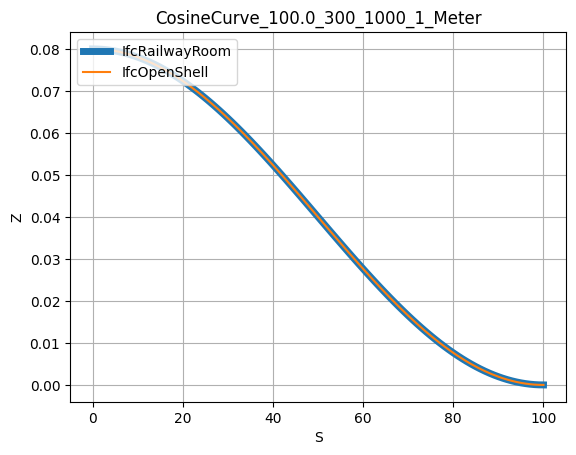

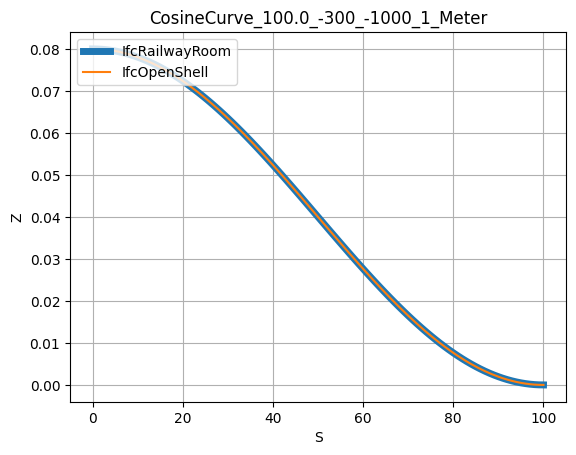

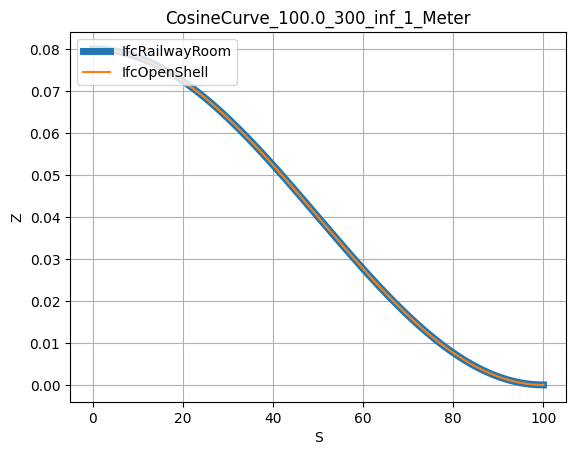

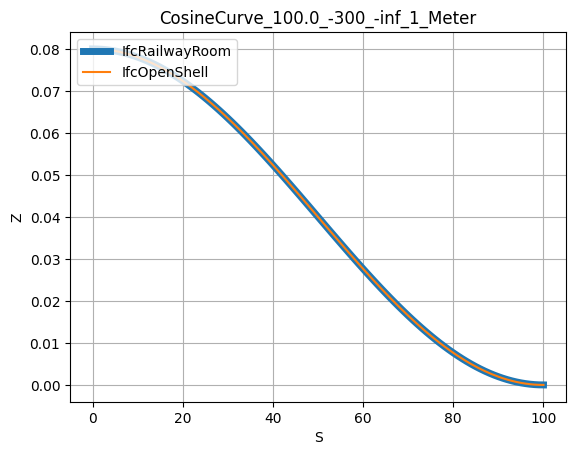

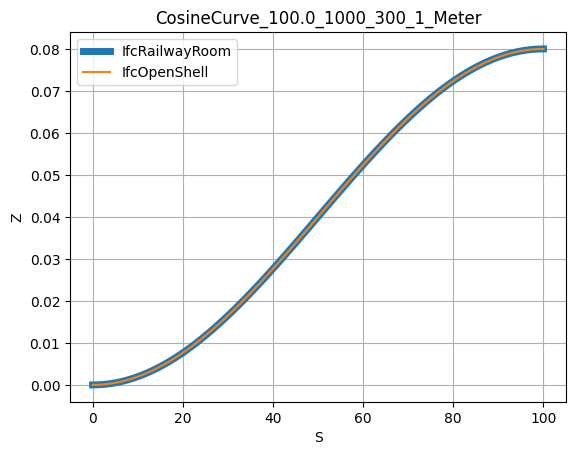

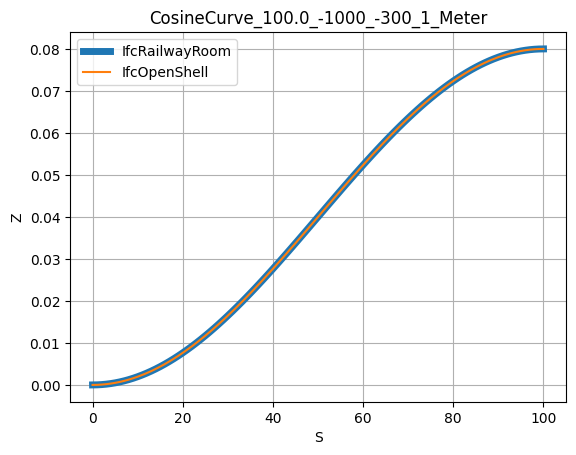

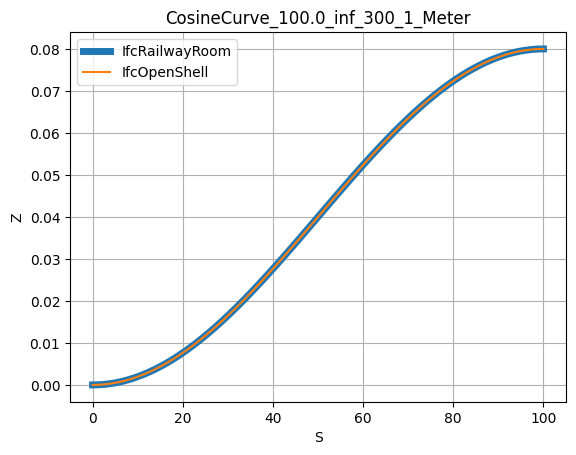

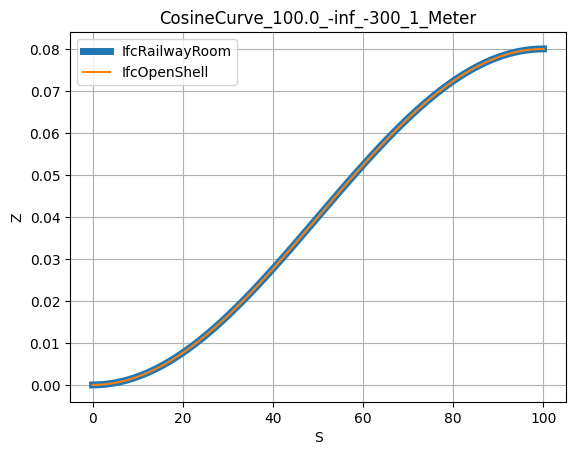

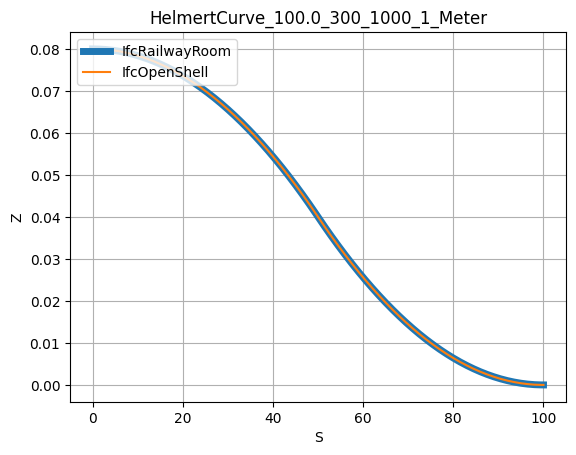

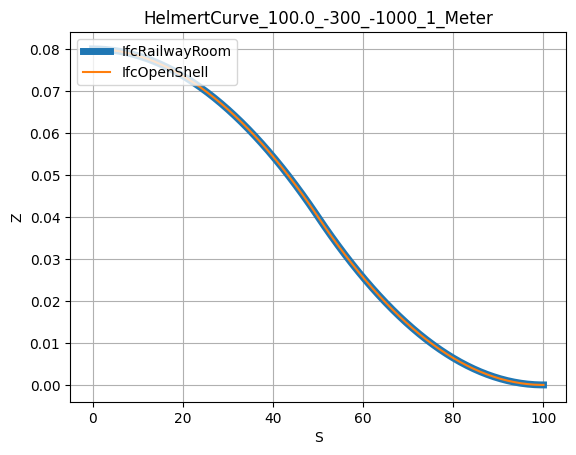

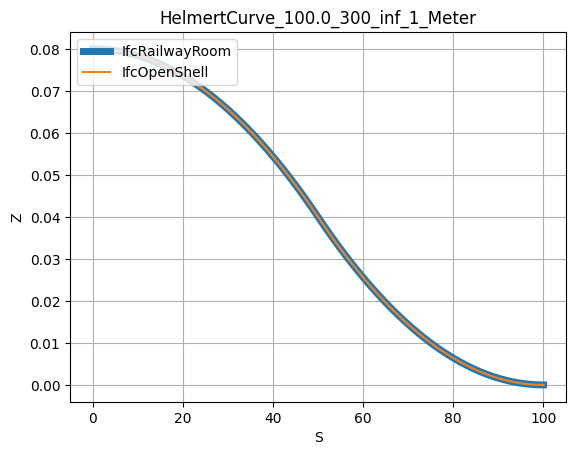

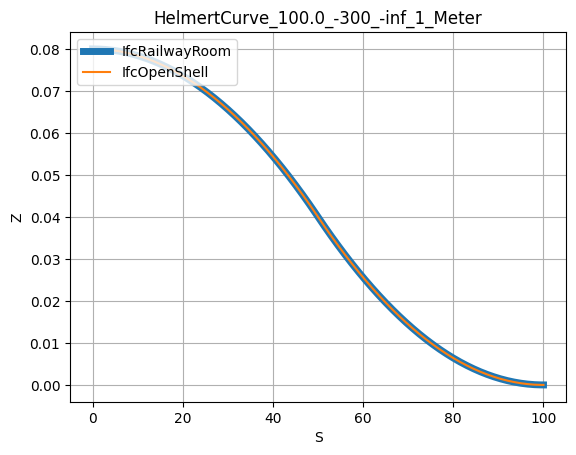

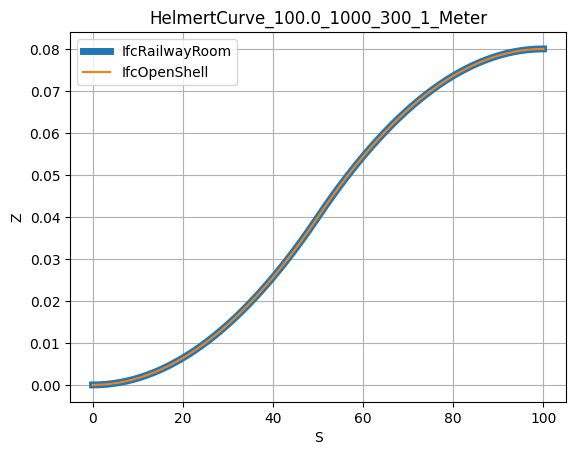

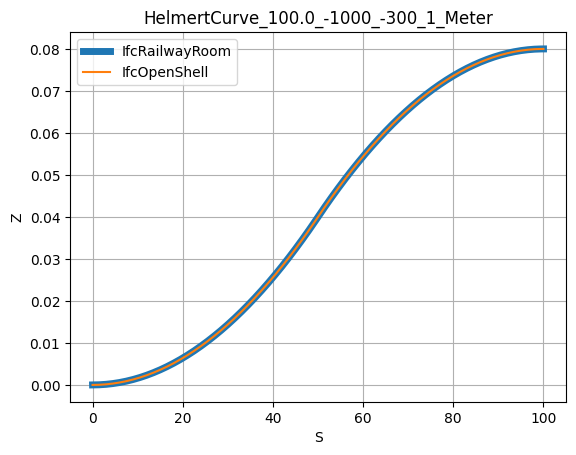

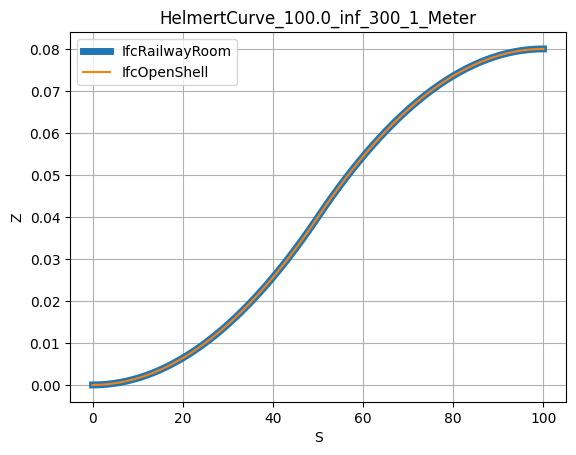

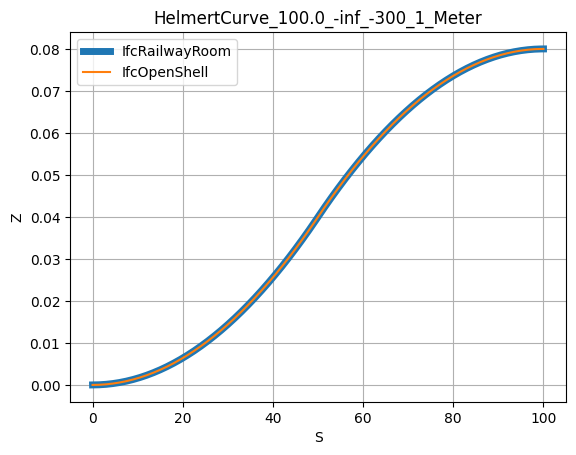

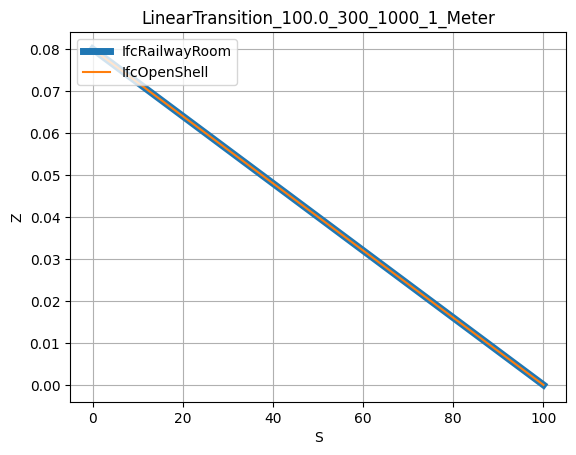

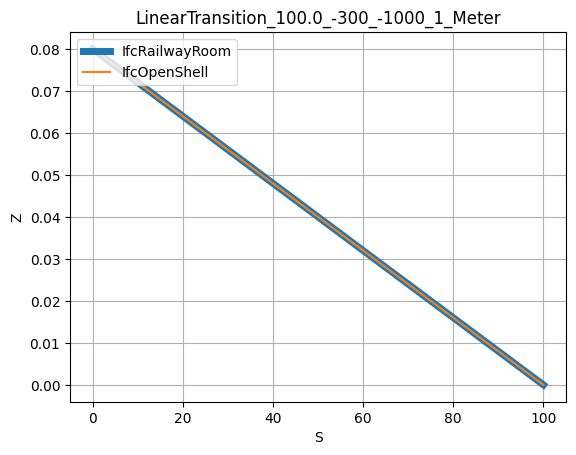

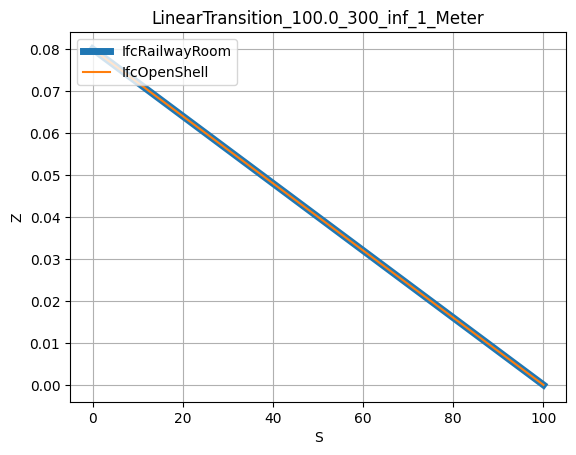

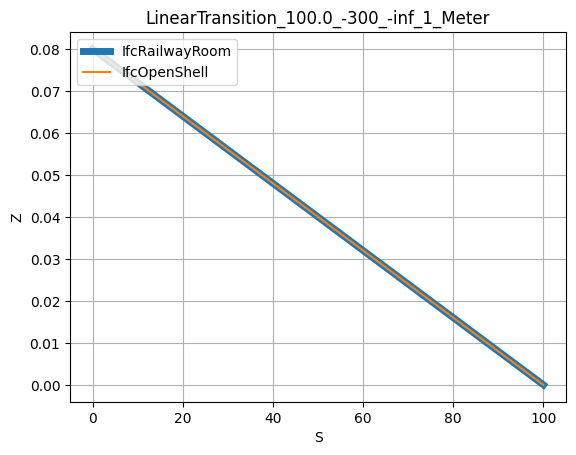

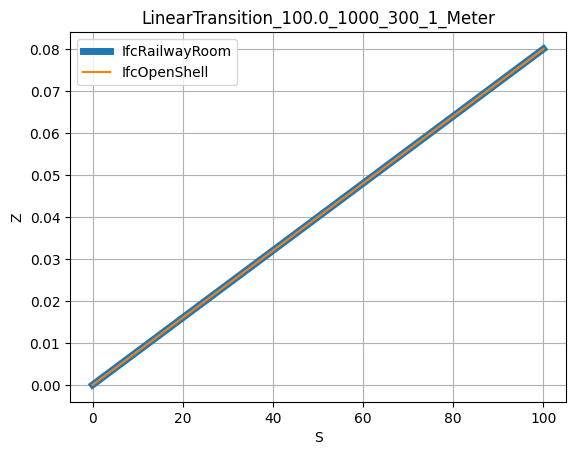

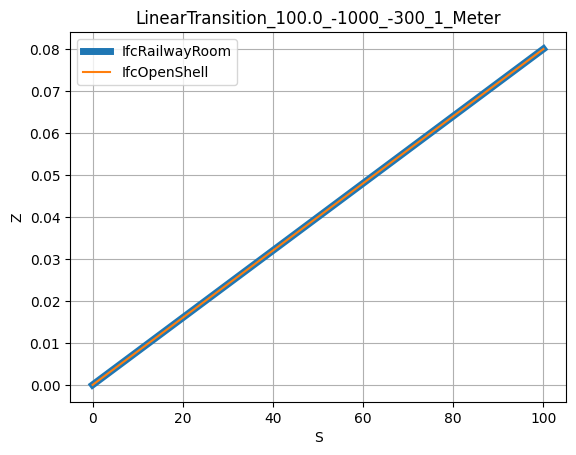

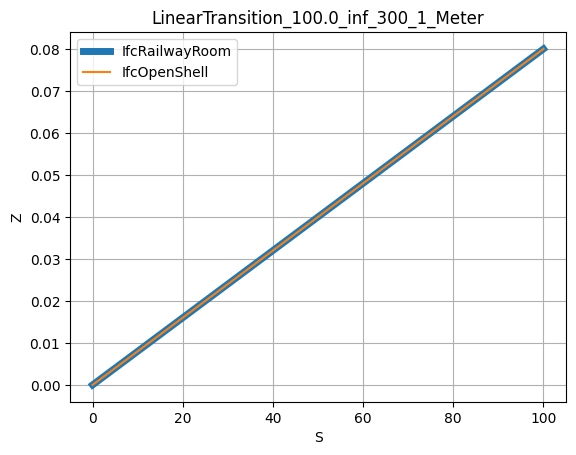

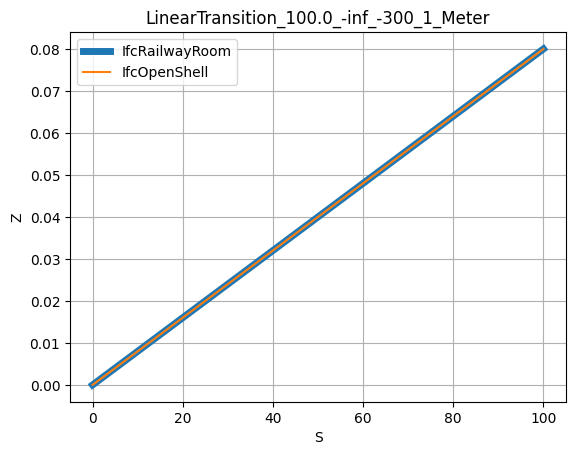

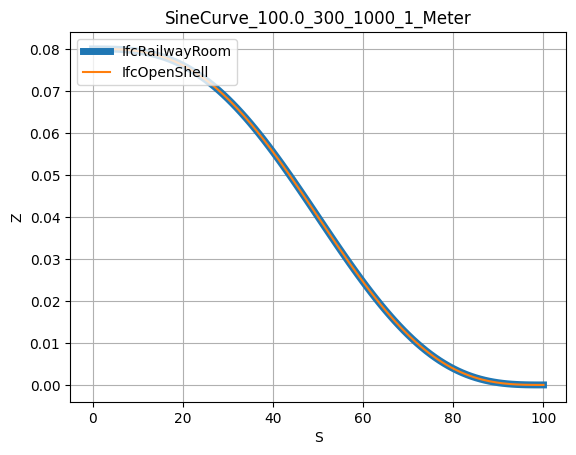

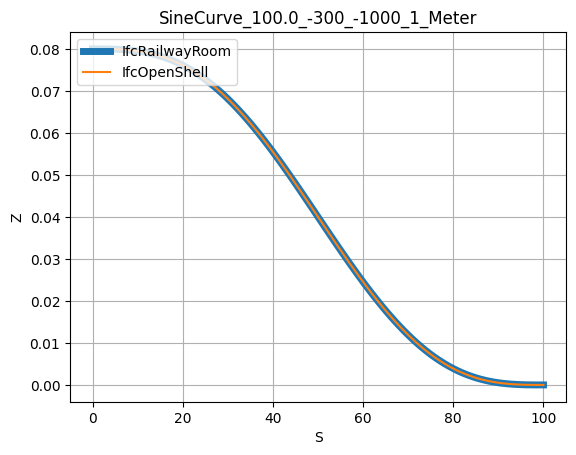

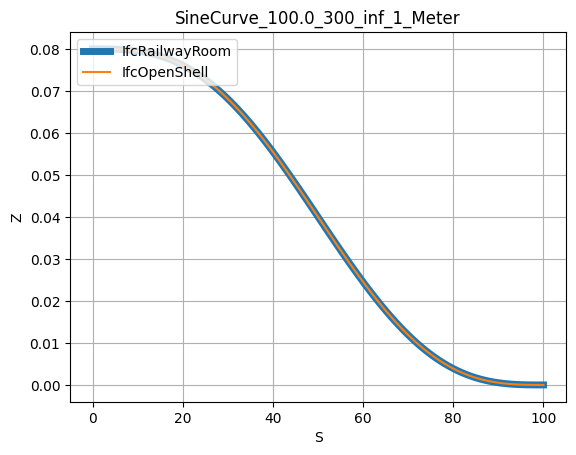

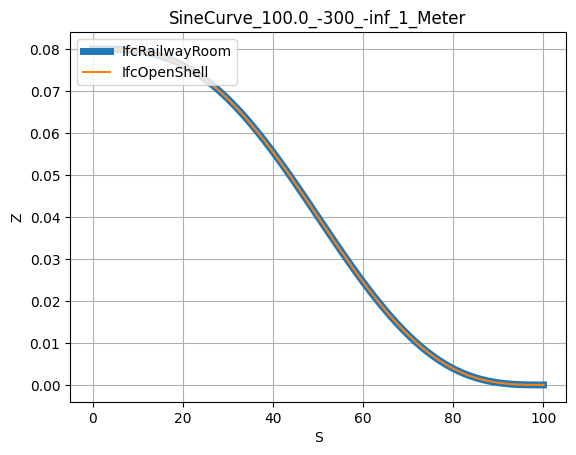

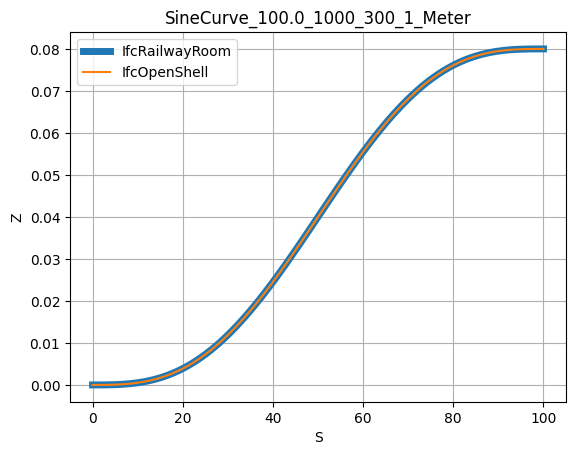

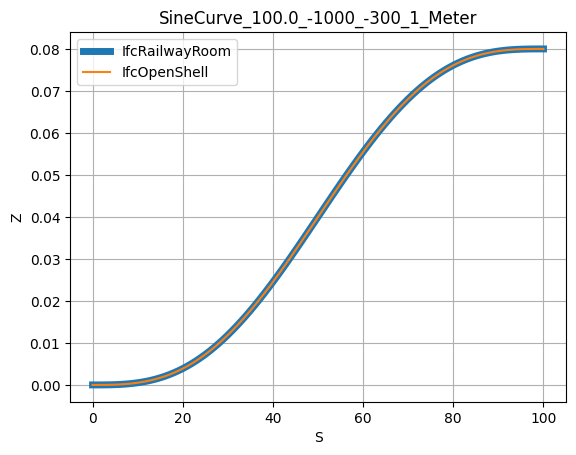

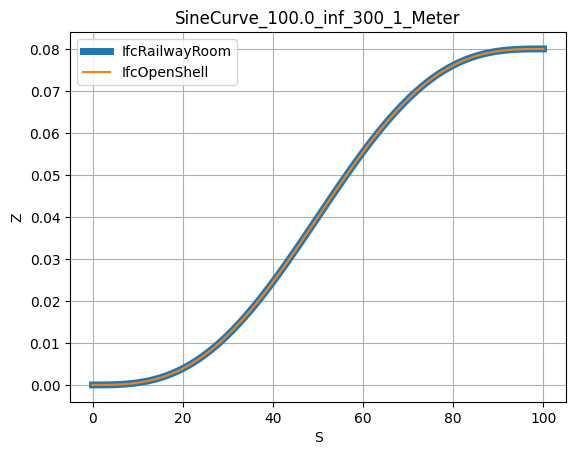

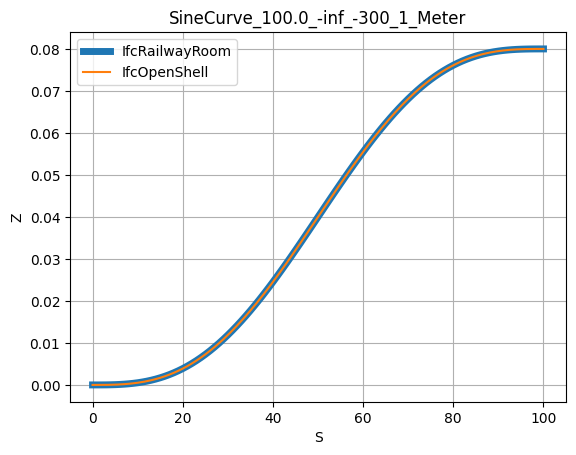

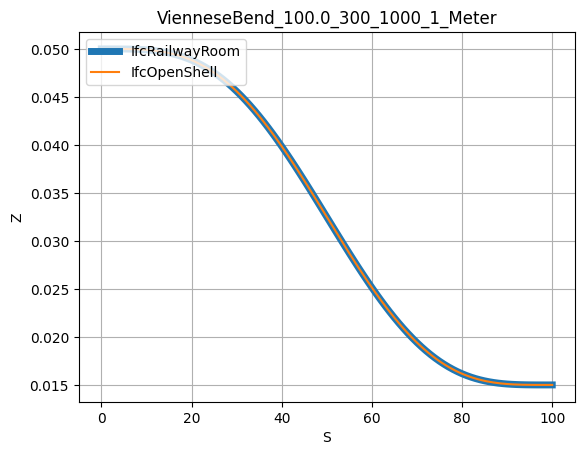

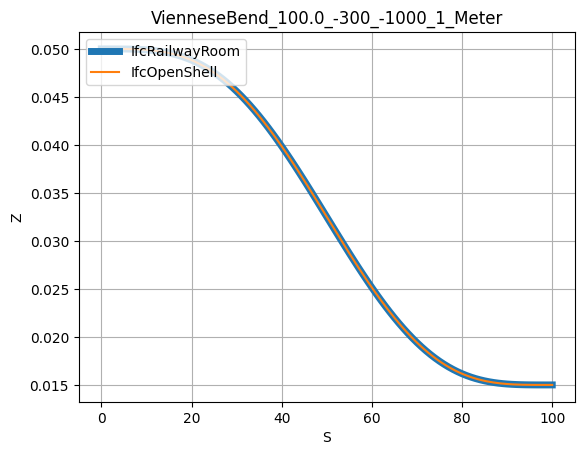

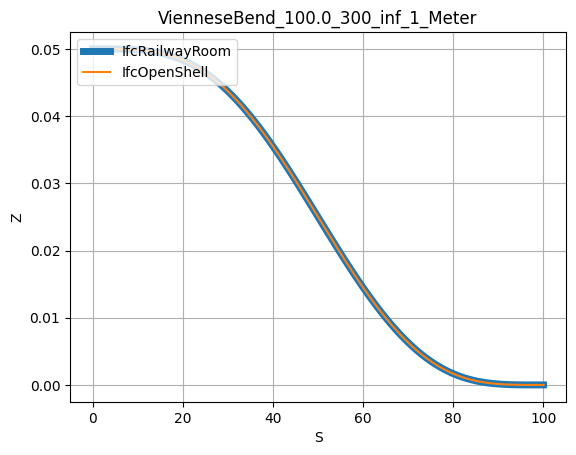

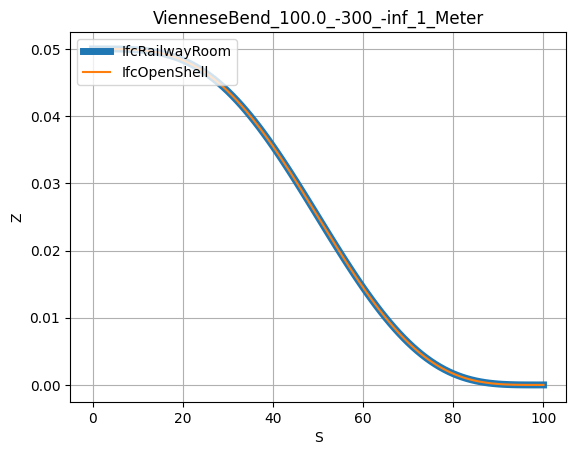

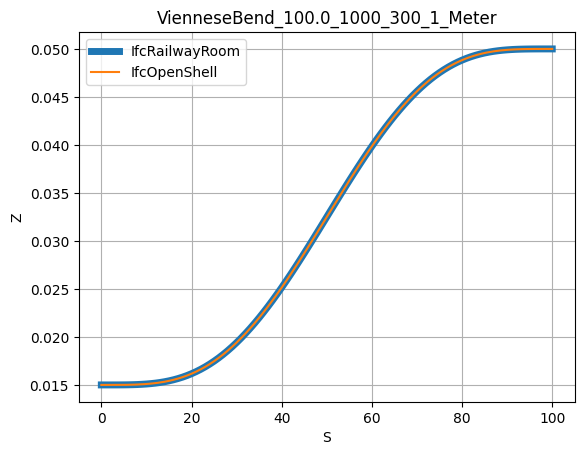

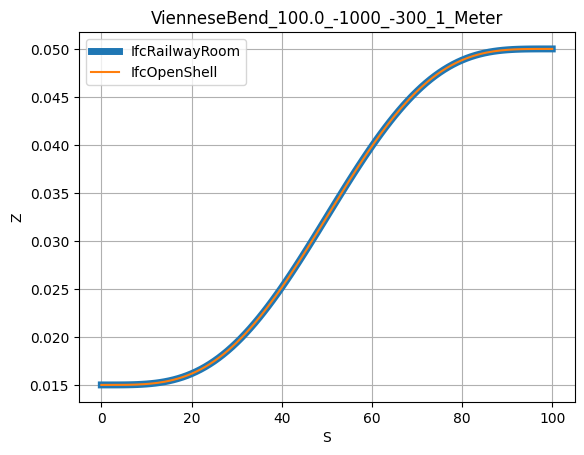

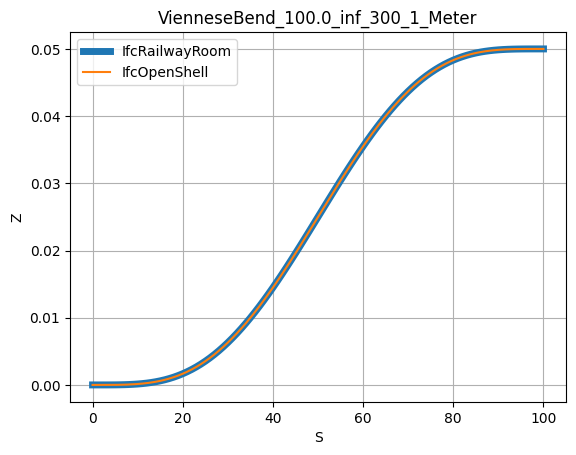

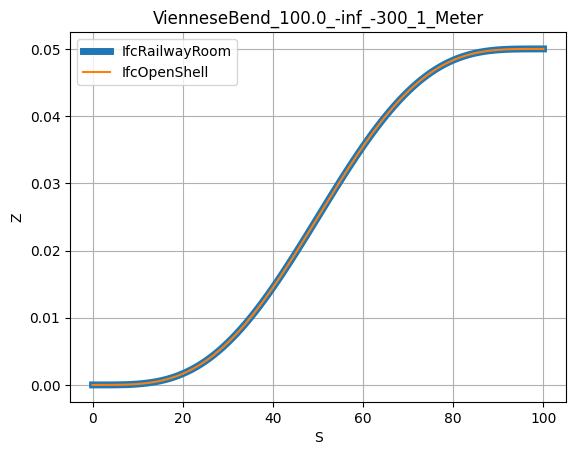

In [1]:
import ifcopenshell
import ifcopenshell.geom as geom
import numpy as np
import matplotlib.pyplot as plt
import ifcopenshell.util.unit
import os

length_unit = "Meter" # make this "Meter" or "Foot"

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))


cd = os.getcwd()
drive = os.path.splitdrive(cd)[0]

settings = geom.settings()

curve_types = ["BlossCurve","ConstantCant","CosineCurve","HelmertCurve","LinearTransition","SineCurve","VienneseBend"]
for curve_type in curve_types:
    test_cases = []
    test_cases.append(curve_type + "_100.0_300_1000_1_Meter")
    test_cases.append(curve_type + "_100.0_-300_-1000_1_Meter")
    test_cases.append(curve_type + "_100.0_300_inf_1_Meter")
    test_cases.append(curve_type + "_100.0_-300_-inf_1_Meter")
    test_cases.append(curve_type + "_100.0_1000_300_1_Meter")
    test_cases.append(curve_type + "_100.0_-1000_-300_1_Meter")
    test_cases.append(curve_type + "_100.0_inf_300_1_Meter")
    test_cases.append(curve_type + "_100.0_-inf_-300_1_Meter")
    
    for test_case in test_cases:
        filename = drive+"/IFC-Rail-Unit-Test-Reference-Code/alignment_testset/IFC-WithFixedGeneratedGeometry/GENERATED__CantAlignment_" + test_case + ".ifc"
        filename = filename.replace("Meter",length_unit)
        model = ifcopenshell.open(filename)
        
        # ifcopenshell works in length units meter
        # get the scale factor for the IFC file units
        unit_scale = ifcopenshell.util.unit.calculate_unit_scale(model)

        # read the results file
        results_file = drive+"/IFC-Rail-Unit-Test-Reference-Code/alignment_testset/ToolboxProcess-C/CantAlignment/" + curve_type + "/" + test_case + "-2CS.txt"
        with open(results_file,'r') as f:
            lines = f.readlines()[2:] # skip the first two header lines
        
        x_values = []
        y_values = []
        for line in lines:
            s,x,y,z = map(float,line.split()[:4])
            d = line.split()[4]
            d = float(d.strip("()"))
            x_values.append(d)
            y_values.append(z)

        # results files are in SI units, convert the arrays to float
        # and convert to the IFC file units
        x_values = np.array(x_values,dtype=float)
        y_values = np.array(y_values,dtype=float)
        x_values *= unit_scale
        y_values *= unit_scale
        
        fig1 = plt.figure().add_subplot()
        fig1.plot(x_values,y_values,label="IfcRailwayRoom",linewidth=5)
    
        curves = model.by_type("IfcSegmentedReferenceCurve",False)
       
        
        # get results from ifcopenshell by calculating values
        for curve in curves:
            shape = geom.create_shape(settings,curve)
            verts = shape.verts
            verts = np.array(verts).reshape((-1,3))
            x,y,z = verts.T

            # convert computed values from SI to IFC file units
            x *= unit_scale
            y *= unit_scale
            z *= unit_scale
            
            # want to plot (dist along, elevation) so need to compute
            # dist along from x,y. the following is probably bad code,
            # I just used Microsoft Copilot to generate it
            # Convert to Numpy arrays
            points = np.array(list(zip(x, y)))
            # Calculate pairwise distances using the Euclidean distance formula
            distances = []
            distances.append(0.0)
            for i in range(len(points)-1):
                dist = euclidean_distance(points[i], points[i+1])
                distances.append(dist + distances[i])
                
        fig1.plot(distances,z,label="IfcOpenShell")

        test_case = test_case.replace("Meter",length_unit)
        fig1.set_title(test_case)
        fig1.legend(loc="upper left")
        #fig1.axis("square")
        fig1.set_xlabel("S")
        fig1.set_ylabel("Z")
        fig1.grid(True)
        plt.show()
